
Rastrigin: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 38.5 MB/s 
     |████████████████████████████████| 872 kB 80.2 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=23f67a7f3420cd30bfe97b598e3a460500076ee0c6194468b030ec1fd148c37d
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=15e6fa86a6b5e7c0bfd4fbb331b880d89862afe740723c020a669ab5ab483f5b
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util = 'EI'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
            
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1662384780.3679368

In [13]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 5.12       -4.63593872]	 66.98540261853682	 19.908403246996286	 3.1524274681614224	 4.421518129242093
2  	 [3.96252493 5.12      ]	 44.902252789663564	 19.908403246996286	 3.2702575033388697	 3.6629056509299778
3  	 [-5.12  5.12]	 57.849427451571785	 19.908403246996286	 3.1975971043805096	 4.049366864974146
4  	 [5.12       0.35651422]	 45.25578453794613	 19.908403246996286	 2.982163883665765	 3.4934042594422703
5  	 [ 0.68278681 -5.12      ]	 43.489624143460475	 19.90

In [14]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [4.83953145 5.12      ]	 57.012390449940355	 18.964539418712707	 3.67017144778887	 4.463732601300035
2  	 [ 5.12 -5.12]	 57.849427451571785	 18.964539418712707	 3.29333776525544	 4.282358220381291
3  	 [-0.27814497  5.12      ]	 40.76127620601005	 18.964539418712707	 3.4743834853501325	 4.041238896390211
4  	 [5.12       0.08530246]	 30.33425930886101	 18.964539418712707	 3.570824962717167	 4.16652954590024
5  	 [-5.12  5.12]	 57.849427451571785	 18.964539418712707	 3.6

In [15]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 2.87042319 -1.98283743]	 15.364229918613852	 10.607662635789808	 2.961830051111131	 2.7970367521236854
2  	 [-4.55938936  5.12      ]	 69.02456548499794	 10.607662635789808	 3.06318860417273	 4.212942107624269
3  	 [ 0.0505194 -5.12     ]	 29.426836219566667	 10.607662635789808	 2.8111246235056955	 3.40063455853421
4  	 [ 5.12 -5.12]	 57.849427451571785	 10.607662635789808	 2.9187700029000827	 3.165585516409637
5  	 [5.12       0.53377994]	 48.985238068961735	 10.6076626357

In [16]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-5.12  5.12]	 57.849427451571785	 14.323038259018315	 3.219803694792671	 3.954977396658721
2  	 [0.36086169 5.12      ]	 45.470798139823216	 14.323038259018315	 3.447690055559676	 3.819009820318697
3  	 [-2.25206489 -5.12      ]	 44.12624747880194	 14.323038259018315	 3.478175856475482	 3.494743666002871
4	 [0.85387468 1.14521907]	 9.849391153287403	 9.849391153287403	 3.3758652344279914	 3.025587652776292
5  	 [-5.12       -3.09046334]	 40.0480331613448	 9.849391153287403	 3

In [17]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 5.12       -4.82923901]	 57.47068160569563	 7.8108627039749745	 3.8356743717937167	 4.556525966014493
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 3.7191904949517705	 4.212794525341343
3  	 [-5.12       -0.04632839]	 29.347543495463746	 7.8108627039749745	 3.5935129282321725	 3.9446046533811625
4  	 [1.00368194 5.12      ]	 29.934767032661334	 7.8108627039749745	 3.302192715949832	 3.8083178013797214
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745

In [18]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [5.12       4.36962522]	 64.84662479988013	 17.28954482757088	 3.9687594544846467	 4.3130258752081785
2  	 [-5.12       -4.52562455]	 69.27665992747993	 17.28954482757088	 3.316545047117406	 4.128126871877352
3  	 [-5.12  5.12]	 57.849427451571785	 17.28954482757088	 3.2124916891529756	 4.050998333284606
4  	 [0.4224903 5.12     ]	 47.94058283305562	 17.28954482757088	 3.094417279206775	 3.6281453551502207
5  	 [-0.90927109 -5.12      ]	 31.332837079939694	 17.28954482757088	

In [19]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 3.005590137810142	 4.008296444071431
2  	 [ 5.12 -5.12]	 57.849427451571785	 22.52235437888213	 3.0713892808770202	 4.0099538803586485
3  	 [3.59868157 5.12      ]	 60.01380648073649	 22.52235437888213	 3.1705347968551707	 3.5334323590219996
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 3.028549690727459	 3.046307140328312
5	 [ 1.40596431 -0.9612239 ]	 21.500727863178327	 21.500727863178327	 2

In [20]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [-5.12  5.12]	 57.849427451571785	 13.871821018360485	 3.148890656041407	 4.085878709003431
2  	 [ 5.12 -5.12]	 57.849427451571785	 13.871821018360485	 3.185055515570803	 3.9299997806834694
3  	 [-5.12       -0.06227621]	 29.684424951100418	 13.871821018360485	 2.9333326740284495	 3.4574396856639917
4  	 [-0.66933997  4.17626884]	 38.274346860266206	 13.871821018360485	 3.349142140292627	 3.426321679169701
5  	 [ 1.18401809 -4.40983344]	 45.258172703673786	 13.871821018360485	

In [21]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.69491889 4.82146316]	 55.95031066333101	 24.454800313488693	 3.0952156607508585	 3.204358037906524
2  	 [-2.73484701  5.12      ]	 47.35475432807173	 24.454800313488693	 3.189439483804398	 4.05195947884252
3  	 [ 4.9139196  -0.89118552]	 28.615751917899416	 24.454800313488693	 2.5996294620061224	 3.1985435029777984
4  	 [ 4.41315104 -5.12      ]	 66.94831945790897	 24.454800313488693	 2.8735611192941315	 3.354837718844402
5  	 [0.37449559 1.6410115 ]	 36.2069296134532

In [22]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [ 5.12       -0.56831489]	 48.34053896150924	 13.839458310244165	 3.155573723257731	 3.704609157759507
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 2.6010879359495926	 3.15203319061488
3  	 [-5.12       -0.60622953]	 47.146193508927205	 13.839458310244165	 3.040108693915674	 3.6094966368675974
4  	 [-5.12  5.12]	 57.849427451571785	 13.839458310244165	 3.4063169941095417	 3.8370587899444053
5  	 [-0.83775595  5.12      ]	 34.387858034337896	 13.839458310244165	

In [23]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 2.910252259613797	 4.082909601971785
2  	 [-5.12  5.12]	 57.849427451571785	 10.679755252484755	 2.7000861899111115	 3.7589702904242683
3  	 [ 5.12       -0.75125888]	 39.410006526902066	 10.679755252484755	 3.2371366656975624	 3.5561617788297526
4  	 [1.2104652 5.12     ]	 37.931362468896026	 10.679755252484755	 2.7009027588555004	 2.6797632450897515
5  	 [-0.21481968 -3.12847858]	 20.726195533629188	 10.679

In [24]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 3.6776527396425984	 3.9651578763895956
2  	 [-5.12       -4.76175942]	 60.86087254020673	 40.51116653209555	 2.69025923362768	 3.4817542887366764
3	 [2.51409012 0.8324447 ]	 32.022881957534196	 32.022881957534196	 2.8587729079618156	 3.0275095973808517
4  	 [0.33259951 5.12      ]	 43.99535293143723	 32.022881957534196	 2.6412592457004878	 3.3802881376673377
5  	 [-0.45714167 -5.12      ]	 48.77330101757837	 32.0228819575341

In [25]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12       -2.70719865]	 48.9106274395484	 17.435826639425656	 2.956877519894405	 3.4306722804065
2  	 [-5.12  5.12]	 57.849427451571785	 17.435826639425656	 2.985682289445841	 3.881641062447303
3  	 [-1.08028523 -5.12      ]	 31.337310832921958	 17.435826639425656	 2.296685015411801	 3.0244058763569166
4	 [-2.85068827  1.13910437]	 17.093700396950695	 17.093700396950695	 2.860633912182621	 2.8561462592375824
5  	 [-1.15643627  5.12      ]	 34.71609150037403	 17.093700396950

In [26]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 3.1780140634133702	 3.8443509257492456
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 3.1644114696190595	 3.900789695149269
3  	 [-5.12        0.35979576]	 45.41851353584756	 10.423838604848608	 2.8260633524756344	 3.6958821428102833
4  	 [ 5.12       -0.06415148]	 29.73023972019508	 10.423838604848608	 2.878784716398354	 3.116822996185402
5  	 [-5.12  5.12]	 57.849427451571785	 10.423838604848608	 2.7662526

In [27]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [2.55186485 5.12      ]	 54.91043298792641	 7.990765314336182	 3.0881738537082546	 3.8171507094400203
2  	 [-5.12  5.12]	 57.849427451571785	 7.990765314336182	 2.7149251418120444	 4.142472986219878
3  	 [5.12       1.18067352]	 36.09923948463857	 7.990765314336182	 2.825696129365773	 3.547968925449694
4  	 [-0.33082192 -5.12      ]	 43.896884199456196	 7.990765314336182	 2.6790999354240994	 3.1603584121445345
5  	 [-1.25750865  4.14832845]	 33.29906954011429	 7.990765314336

In [28]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [3.58163634 5.12      ]	 60.46590587006904	 22.27210456874814	 3.6660766989171574	 4.0201580891181985
2  	 [5.12       0.27386714]	 40.49371891710378	 22.27210456874814	 3.5756932771939947	 3.458853667171313
3  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 3.413857450995418	 3.813658237470946
4  	 [0.98591544 1.56931673]	 22.540382524098554	 22.27210456874814	 2.824713553993009	 3.195392994921489
5  	 [ 5.12 -5.12]	 57.849427451571785	 22.27210456874814	 2.618041545163

In [29]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 20.395145364684023	 3.315476681130734	 4.599696523929133
2  	 [-5.12  5.12]	 57.849427451571785	 20.395145364684023	 3.362397035023204	 3.6021760881842293
3  	 [-0.24401625  5.12      ]	 38.60837606076735	 20.395145364684023	 2.949515021251649	 3.5630013189318372
4  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 3.173440090121636	 3.690050629262533
5  	 [ 1.07734624 -3.51435277]	 34.628541794158	 20.395145364684023	 3.20507705473514

In [30]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 3.00450163515948	 3.858257995709437
2  	 [-5.12       -1.37231578]	 47.758775229357255	 22.67190580753611	 2.9707100640013104	 2.982795831549052
3  	 [-1.30204395  2.41812383]	 39.46036109720558	 22.67190580753611	 4.047553022470944	 3.3555992469642373
4  	 [ 1.04792652 -5.12      ]	 30.472847844331426	 22.67190580753611	 3.436847553085417	 3.640948868926005
5  	 [-1.4623386  -1.33673408]	 38.83051174077087	 22.67190580

In [31]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 3.1819817603290925	 4.721091043993306
2  	 [ 1.77597011 -1.68637198]	 28.265620307761434	 25.867003842388073	 3.561953161907329	 3.4306546247492897
3  	 [5.12 5.12]	 57.849427451571785	 25.867003842388073	 3.8664248583025556	 4.124295712286749
4  	 [-1.28677787  5.12      ]	 42.8708215992574	 25.867003842388073	 3.0451436127651443	 2.9939229626057333
5  	 [-5.12      -0.9783971]	 29.97395322055487	 25.867003842388073	 2.81

In [32]:
### ESTIMATED STP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 3.143128910720323	 3.8333158726702288
2  	 [ 5.12       -0.92645866]	 30.831740520037826	 17.388691338534382	 2.8145574531702207	 3.780945254642499
3  	 [ 5.12 -5.12]	 57.849427451571785	 17.388691338534382	 2.9041791000835633	 3.176996314020707
4  	 [-2.70374718  5.12      ]	 49.10037798927078	 17.388691338534382	 3.264302601658532	 3.515540180888605
5  	 [-1.34020595 -5.12      ]	 46.09005495517293	 17.388691338534382	 2

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1662385715.113649

In [34]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 3.1524274681614224	 4.421518129242093
2  	 [4.42977754 2.01541797]	 42.77403520305755	 19.908403246996286	 3.270389009242551	 3.664418274859568
3  	 [ 0.1047149  -3.68117597]	 29.840326213156384	 19.908403246996286	 2.9014251492419754	 4.175143135607348
4  	 [-4.89958599  4.58721496]	 65.50937696421485	 19.908403246996286	 3.459463034801761	 4.111411769642945
5  	 [ 1.84587273 -0.35518185]	 24.00539299484

In [35]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    	    
1  	 [4.81874241 3.07464552]	 39.56740440269988	 18.964539418712707	 3.67017144778887	 4.463732601300035
2  	 [ 4.84260546 -3.96517156]	 43.916134329740714	 18.964539418712707	 3.4351281785328593	 4.419552893967704
3  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 3.3435348563630396	 4.002171409364298
4  	 [0.70799905 3.12454697]	 25.781362594131053	 18.964539418712707	 2.5616788568773066	 3.5964090593393503
5  	 [-5.12       -1.22959612]	 39.158115404957606	 18.96

In [36]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    	    
1  	 [ 2.87042319 -1.98283743]	 15.364229918613852	 10.607662635789808	 2.961830051111131	 2.7970367521236854
2  	 [-3.19677619  4.62951673]	 55.23721089925957	 10.607662635789808	 3.06318860417273	 4.212942107624269
3  	 [-0.49026183 -3.21838369]	 38.606165068807485	 10.607662635789808	 2.479673616052189	 3.7572576196403893
4  	 [4.89423267 0.02817073]	 26.238638237873694	 10.607662635789808	 3.1031616126049966	 3.9907198296739366
5  	 [ 2.66793959 -4.83122769]	 50.50424889035734

In [37]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 3.219803694792671	 3.954977396658721
2  	 [-0.9356617   4.54448646]	 41.945730234899074	 14.323038259018315	 2.886174172371101	 3.5703075466979484
3  	 [-1.02597618 -5.12      ]	 30.11023811573171	 14.323038259018315	 2.7752681451438983	 3.8242606550680165
4  	 [0.49976441 1.02192631]	 21.388835716483523	 14.323038259018315	 3.3117074781273574	 3.456095317513765
5  	 [-4.97003202  3.52793521]	 57.170650859244	 14.323038259

In [38]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    	    
1  	 [ 4.32895605 -5.09732646]	 61.29478907190488	 7.8108627039749745	 3.8356743717937167	 4.556525966014493
2  	 [4.02415917 4.76321328]	 48.16778619122226	 7.8108627039749745	 3.8259413912957996	 4.056521608699057
3  	 [-5.12000000e+00 -1.02271084e-03]	 28.924921230791284	 7.8108627039749745	 3.500776259724456	 3.798601251071965
4  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 3.39668614466324	 3.4450260589609067
5  	 [ 1.25843274 -3.12193857]	 24.653983172971397	 

In [39]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 3.9687594544846467	 4.3130258752081785
2  	 [4.48914029 2.92869999]	 49.6932034994741	 17.28954482757088	 3.1361933159126294	 4.088497974487699
3  	 [-1.20203668 -5.06547439]	 34.970040481603995	 17.28954482757088	 3.3418600590876055	 3.9873499916074895
4  	 [-2.91508567  4.40569092]	 47.5928067251325	 17.28954482757088	 2.968726725451691	 4.3210253195160195
5  	 [0.91848973 5.08934792]	 29.562965758813867	 17.289544827570

In [40]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 3.005590137810142	 4.008296444071431
2  	 [3.36336072 4.52412691]	 68.20074440954015	 22.52235437888213	 3.0713892808770202	 4.0099538803586485
3  	 [ 3.81570236 -4.87523301]	 47.234127813742255	 22.52235437888213	 3.2730748689604425	 3.7286815609309363
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 3.0285619241944337	 3.046307140328312
5	 [ 1.13453878 -0.82926653]	 10.562931859398235	 10.56293

In [41]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    	    
1  	 [ 4.96383424 -4.82578382]	 53.60118142988121	 13.871821018360485	 3.148890656041407	 4.085878709003431
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 3.31768325059745	 3.78754875821598
3  	 [-5.12       -2.11136579]	 35.73243029163747	 13.871821018360485	 2.9917237096486002	 3.672794705419105
4  	 [ 1.09080552 -4.27732061]	 32.77746248841899	 13.871821018360485	 3.274569647842853	 3.6307088465578627
5  	 [-0.5310758   2.96460578]	 29.127176814398545	 13

In [42]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    	    
1  	 [3.69491889 4.82146316]	 55.95031066333101	 24.454800313488693	 3.0952156607508585	 3.204358037906524
2  	 [-2.02106223  4.82097351]	 33.10085788033846	 24.454800313488693	 3.189439483804398	 4.05195947884252
3	 [1.9771472  0.74713585]	 14.750184067763719	 14.750184067763719	 2.635064735105204	 3.5029034060809856
4  	 [ 4.43889093 -3.24498238]	 59.19033586136056	 14.750184067763719	 2.7005694103729647	 3.6471688610695323
5  	 [5.026706   1.32904654]	 41.93954304108088	 1

In [43]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    	    
1  	 [5.12       0.59896323]	 47.41175831671596	 13.839458310244165	 3.155573723257731	 3.704609157759507
2  	 [-4.53780345 -0.81355647]	 47.08468825435077	 13.839458310244165	 2.535097950853813	 3.3620442033782942
3  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 3.433227726772619	 3.7260587528014177
4	 [-1.12192523  0.07570431]	 5.168211542144556	 5.168211542144556	 3.451563341317921	 3.634525001889794
5  	 [-0.34271121  5.12      ]	 44.54347993900822	 5.16821154214455

In [44]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 2.910252259613797	 4.082909601971785
2  	 [ 2.45710354 -0.83288647]	 31.394363858898753	 10.679755252484755	 2.7000861899111115	 3.7589702904242683
3  	 [-3.67755831  2.64141021]	 51.20330278744583	 10.679755252484755	 3.491717773908175	 4.255756939073135
4  	 [-0.23509426 -3.34993652]	 36.216782218317746	 10.679755252484755	 2.9538034784930898	 3.28841980523627
5  	 [0.09790516 5.12      ]	 30.76746646197081

In [45]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 3.6776527396425984	 3.9651578763895956
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 2.69025923362768	 3.4817542887366764
3  	 [-0.46166813 -5.12      ]	 48.84921587525349	 40.51116653209555	 2.7337294807061703	 3.002947780957033
4	 [2.52357387 1.19386188]	 34.229660778936314	 34.229660778936314	 2.571002774949662	 2.5130742411137335
5  	 [-5.12       -1.54249457]	 50.94966746568011	 34.229660778936314	 2.152327

In [46]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.435826639425656	 2.956877519894405	 3.4306722804065
2  	 [-3.79946932  2.66821301]	 43.412509428311274	 17.435826639425656	 2.5389166878714597	 3.731942673828179
3  	 [-2.15178595 -1.49579183]	 31.07737996083779	 17.435826639425656	 2.4633440313232726	 3.2957606543044857
4  	 [-0.50423444 -5.12      ]	 49.175426966944855	 17.435826639425656	 3.0364514618386087	 3.8651284944789217
5  	 [-4.99747285 -0.8426771 ]	 30.186574680483698	 17.43582

In [47]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    	    
1  	 [-4.98996551 -5.12      ]	 53.844338556563216	 10.423838604848608	 3.1780140634133702	 3.8443509257492456
2  	 [5.12       1.43373874]	 50.126106106866246	 10.423838604848608	 3.153703369901504	 3.8840234176321444
3  	 [-5.12        0.36751971]	 45.79082563073787	 10.423838604848608	 2.978827363948065	 3.6839806448298758
4  	 [-1.70393766  0.0408019 ]	 16.08583675588006	 10.423838604848608	 2.7542992283676737	 3.0032191881373924
5  	 [5.12 5.12]	 57.849427451571785	 10.423

In [48]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    	    
1  	 [2.50790132 5.12      ]	 55.20196193079832	 7.990765314336182	 3.0881738537082546	 3.8171507094400203
2  	 [-4.96635744  4.09320867]	 43.30810083468987	 7.990765314336182	 2.7139639356973566	 4.14431989651262
3  	 [2.15619748 0.77474512]	 18.142446990160977	 7.990765314336182	 3.0706350407124163	 3.570014356164829
4  	 [-0.71760179 -5.12      ]	 41.46127607456661	 7.990765314336182	 3.0085485351694934	 3.6519504434494205
5  	 [-1.30096187  4.88816352]	 41.10316652509651	 7.9

In [49]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    	    
1  	 [2.142749   4.83374619]	 36.69381850109535	 22.27210456874814	 3.6660766989171574	 4.0201580891181985
2  	 [4.5921165  0.66584749]	 54.94667333340431	 22.27210456874814	 3.631396290559891	 3.7835870651067225
3  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 3.313319513075197	 3.888453022399422
4  	 [0.71913965 0.71913965]	 24.8880941829524	 22.27210456874814	 2.694311881154959	 3.802366357713522
5  	 [-5.12       -1.66043296]	 47.017030730991706	 22.27210456874814	 2.88

In [50]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 3.315476681130734	 4.599696523929133
2  	 [-1.95646705  4.77829278]	 35.26326039091227	 20.395145364684023	 3.3628610575978883	 3.614133676716341
3  	 [4.67136791 4.9849391 ]	 61.45808001353926	 20.395145364684023	 2.923773318993859	 3.68720013916326
4  	 [ 0.86616148 -3.39433268]	 33.47982869959352	 20.395145364684023	 3.42278725032201	 3.892172609019921
5  	 [-4.60668397  2.49125822]	 65.24908325796068	 20.3

In [51]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 3.00450163515948	 3.858257995709437
2  	 [-5.12       -1.55738046]	 50.70724027251626	 22.67190580753611	 2.9707100640013104	 2.982795831549052
3	 [-1.81759401  0.24145562]	 18.70482086608838	 18.70482086608838	 4.047526546871867	 3.3726401973858477
4  	 [ 0.75882502 -4.72833594]	 43.73576125514902	 18.70482086608838	 3.259803455450866	 3.857405809461955
5  	 [5.12 5.12]	 57.849427451571785	 18.70482086608838	 3.1139662

In [52]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    	    
1  	 [ 4.82682643 -3.73084389]	 53.77630571268805	 25.867003842388073	 3.1819817603290925	 4.721091043993306
2	 [-0.05107128 -0.29851312]	 13.603354132536392	 13.603354132536392	 3.553386660475723	 3.8340618691117885
3  	 [5.12 5.12]	 57.849427451571785	 13.603354132536392	 3.9567367320747215	 4.359555242982022
4  	 [-4.9431446  -0.94431705]	 26.563547885069152	 13.603354132536392	 3.276077901306654	 3.75331300891261
5  	 [-1.02706361  4.62573165]	 39.63496959139912	 13.60335413253

In [53]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 3.143128910720323	 3.8333158726702288
2  	 [-1.37237114 -5.12      ]	 47.761427444187845	 17.388691338534382	 2.8145574531702207	 3.780945254642499
3  	 [ 4.91315823 -0.57399286]	 44.8592687455342	 17.388691338534382	 2.816603608066439	 3.352972453150892
4  	 [-2.37472126  4.83460371]	 51.00240059573831	 17.388691338534382	 3.3034009425241595	 3.807303426574061
5  	 [-5.12       -1.50848283]	 51.18603351747455	 17.38869133

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


901.99161028862

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.9417518504842763, 0.270932813777644)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.80079157537281, 2.9425708889884663)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(2.361576630127625, 2.361576630127625)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(2.287409641424572, 1.5986801068115295)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.05551541920764, 2.05551541920764)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.763872073780371, 2.0954780809846123)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.5636817688099742, 2.357350877944353)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6298595175876263, 2.477760762852301)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.763688455794892, 1.493717669753133)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.5181190215010476, 1.6425266987200722)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.152034925752869, 2.3683499168354514)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(2.2096306584146355, 2.679656202706227)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.759561029420595, 1.7118406464831557)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(2.3440953566682032, 2.3440953566682032)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.078286539213237, 2.078286539213237)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(3.103334979217682, 2.50330381657554)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.459115200457475, 2.1886860382988744)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.540917357953141, 1.8204770515329742)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.9978156826675844, 2.610316389726852)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.819155978849279, 2.738805880413265)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

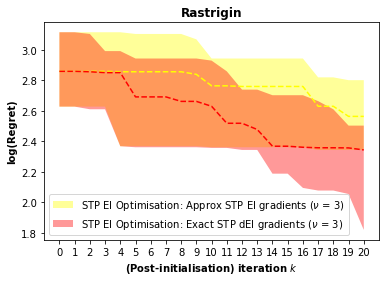

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow', ls='--')
plt.plot(median_exact, color = 'Red', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='STP EI Optimisation: Approx STP EI gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='STP EI Optimisation: Exact STP dEI gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_approx, time_exact


(934.7456021308899, 901.99161028862)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.mean(acqFuncExact_exact_1)
a1 = np.mean(acqFuncApprox_exact_1)

e1, a1


(2.906523897881339, 3.3523733199778976)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.mean(acqFuncExact_exact_2)
a2 = np.mean(acqFuncApprox_exact_2)

e2, a2


(3.006833834014953, 3.488339743866279)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.mean(acqFuncExact_exact_3)
a3 = np.mean(acqFuncApprox_exact_3)

e3, a3


(2.964068168480085, 3.2571595560930175)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.mean(acqFuncExact_exact_4)
a4 = np.mean(acqFuncApprox_exact_4)

e4, a4


(2.849981332753422, 3.3020899119324314)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.mean(acqFuncExact_exact_5)
a5 = np.mean(acqFuncApprox_exact_5)

e5, a5


(3.0233469988555255, 3.2862003152261643)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.mean(acqFuncExact_exact_6)
a6 = np.mean(acqFuncApprox_exact_6)

e6, a6


(2.998579511086141, 3.5047634505914096)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.mean(acqFuncExact_exact_7)
a7 = np.mean(acqFuncApprox_exact_7)

e7, a7


(2.9945226008416532, 3.4153181716291114)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.mean(acqFuncExact_exact_8)
a8 = np.mean(acqFuncApprox_exact_8)

e8, a8


(3.0302425396892945, 3.2482161245951438)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.mean(acqFuncExact_exact_9)
a9 = np.mean(acqFuncApprox_exact_9)

e9, a9


(2.8186144860924833, 3.220970091852275)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.mean(acqFuncExact_exact_10)
a10 = np.mean(acqFuncApprox_exact_10)

e10, a10


(2.9496411141872905, 3.478923472194407)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.mean(acqFuncExact_exact_11)
a11 = np.mean(acqFuncApprox_exact_11)

e11, a11


(3.0360282069262543, 3.4601111482551503)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.mean(acqFuncExact_exact_12)
a12 = np.mean(acqFuncApprox_exact_12)

e12, a12


(2.766740398256033, 3.1215507169398085)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.mean(acqFuncExact_exact_13)
a13 = np.mean(acqFuncApprox_exact_13)

e13, a13


(2.9628302654643788, 3.570608950447183)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.mean(acqFuncExact_exact_14)
a14 = np.mean(acqFuncApprox_exact_14)

e14, a14


(2.8756062649537673, 3.219717704565446)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.mean(acqFuncExact_exact_15)
a15 = np.mean(acqFuncApprox_exact_15)

e15, a15


(2.825747955887124, 3.3035826174253287)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.mean(acqFuncExact_exact_16)
a16 = np.mean(acqFuncApprox_exact_16)

e16, a16


(2.9357091640996513, 3.2682500168703386)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.mean(acqFuncExact_exact_17)
a17 = np.mean(acqFuncApprox_exact_17)

e17, a17


(2.9419734458267843, 3.34795429609171)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.mean(acqFuncExact_exact_18)
a18 = np.mean(acqFuncApprox_exact_18)

e18, a18


(2.941981868079542, 3.413967967948513)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.mean(acqFuncExact_exact_19)
a19 = np.mean(acqFuncApprox_exact_19)

e19, a19


(2.9876597603176913, 3.5254198773425607)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.mean(acqFuncExact_exact_20)
a20 = np.mean(acqFuncApprox_exact_20)

e20, a20


(2.944664374689963, 3.411277470775969)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(2.938064809419169, 3.359839746231007)

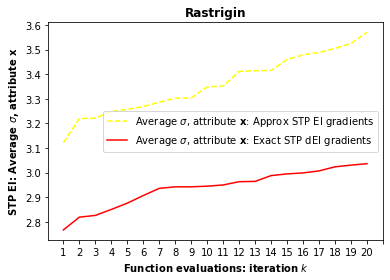

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Yellow', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Approx STP EI gradients')
plt.plot(exact_stddev, color = 'Red', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('STP EI: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
